In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

In [3]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [4]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df.head()

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE


In [5]:
train_df, test_df = train_test_split(
    all_df,
    train_size=0.8,
    shuffle=True,
    random_state=1
)

In [6]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [8]:
from tensorflow.keras.applications.resnet import ResNet101

resNet = ResNet101(include_top = False,
                       input_shape = (120,120,3),
                       weights ='imagenet')

171446536/171446536 [==============================] - 1s 0us/step


In [9]:
x = tf.keras.layers.Flatten()(resNet.output)
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)

In [10]:
model = tf.keras.Model(inputs = resNet.input,outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 126, 126, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 60, 60, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 60, 60, 64)   256         ['conv1_conv[0][0]']         

In [11]:
tf.random.set_seed(42)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
800/800 [==============================] - 358s 336ms/step - loss: 0.0484 - accuracy: 0.9877 - val_loss: 21.3518 - val_accuracy: 0.5205
Epoch 2/100
800/800 [==============================] - 189s 236ms/step - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.2359 - val_accuracy: 0.9447
Epoch 3/100
800/800 [==============================] - 188s 235ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0047 - val_accuracy: 0.9986
Epoch 4/100
800/800 [==============================] - 188s 235ms/step - loss: 0.0182 - accuracy: 0.9950 - val_loss: 0.0930 - val_accuracy: 0.9780
Epoch 5/100
800/800 [==============================] - 187s 234ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.0079 - val_accuracy: 0.9983
Epoch 6/100
800/800 [==============================] - 188s 235ms/step - loss: 0.0091 - accuracy: 0.9968 - val_loss: 0.3084 - val_accuracy: 0.9281


In [13]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"], digits=4)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.00375
Test Accuracy: 99.91%
250/250 [==============================] - 26s 94ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


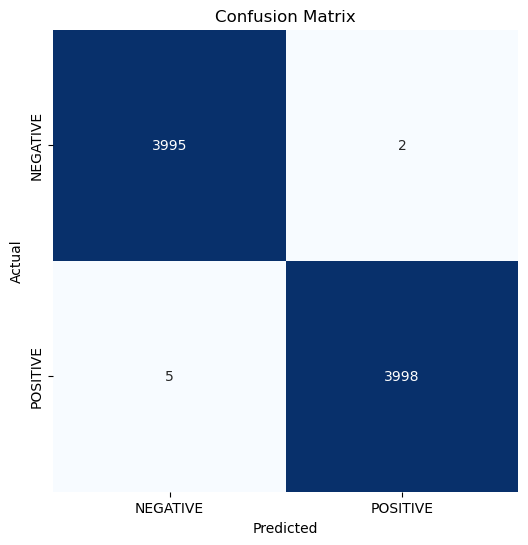

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE     0.9988    0.9995    0.9991      3997
    POSITIVE     0.9995    0.9988    0.9991      4003

    accuracy                         0.9991      8000
   macro avg     0.9991    0.9991    0.9991      8000
weighted avg     0.9991    0.9991    0.9991      8000



In [14]:
evaluate_model(model, test_data)

In [15]:
model.predict(test_data)

250/250 [==============================] - 24s 96ms/step


array([[1.6257899e-04],
       [9.9999738e-01],
       [1.4777984e-04],
       ...,
       [1.0000000e+00],
       [1.5179851e-04],
       [8.4150612e-05]], dtype=float32)

In [17]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (120, 120, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/kaggle/input/test-img/Cracked-Concrete-Foundation.jpg')
pred = model.predict(image)


if pred < 0.5:
    print("No Crack")
else:
    print("Crack")
    

1/1 [==============================] - 0s 42ms/step
Crack
